In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.optimize import minimize, approx_fprime

In [2]:
import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 1000
mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True 
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})

# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })

def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )

In [3]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.998e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.989e33
# G = c = 1

# DIMENSIONS CHECKED
def lamba_metric(M, R):
    # Removed factor of 2 since the paper didnt implement it. 
    return -np.log((1-2*G*M/(c**2*R)))

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.998e10)**2)
    pressure = p*((2.998e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()

def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value=(0, 0), 
                          kind = "linear", bounds_error=False)
    return f_e_smooth

In [4]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _b(r, M):
    return (2*G*M)/((c**2)*r)

# DIMENSIONS CHECKED
def _dvdr(r, Q, lamda):
    return (2/r) * np.exp(lamda) * Q

# DIMENSIONS CHECKED
def _Q(r, P, M):
    frac = (4 * np.pi * G * (r**2)*P)/(c**4)
    return _b(r, M) + frac

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):    
    # dphidr (From other cowling: arXiv1012.4042)
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

In [5]:
# Working in manual cgs units here. 

# DIMENSIONS CHECKED
def _dWdlnr(r, W, U, Q, lamda, l, omega, v, c_ad2):
    term1 = -1*(l+1)*(W-l*np.exp(v+lamda/2)*U)
    frac1 = (np.exp(lamda/2) * (omega*r)**2)/(c_ad2)
    frac2 = (np.exp(lamda/2)*Q*W*(c**2))/((omega*r)**2)
    term2 = frac1 * (U - frac2)
#     print(np.exp(lamda/2), Q, W, r)
#     print(term1 - term2)
    return term1 - term2

# DIMENSIONS CHECKED
def _dUdlnr(r, W, U, lamda, l, v):
    return np.exp(lamda/2 - v) * (W - l*(np.exp(v-lamda/2))*U)

In [6]:
def dedp_arr(p, EOS):
    x = np.linspace(min(p), max(p), int(1e2))
    y = EOS(x)
    dydx = np.diff(y)/np.diff(x)
    return x, dydx

def get_dedp(dedp, p):
    dedp_EQ = interp1d(p[:-1], dedp, fill_value="extrapolate")
    return dedp_EQ

In [7]:
def coupledTOV(r, VEC, init_params):
    P, M, v, W, U = VEC
    EOS, l, omega, dedp_EQ = init_params
    lamda = lamba_metric(M, r)
    Q = _Q(r, P, M)
    
    e = EOS(P)
    
    # Method 1
#     eps = 1e5
#     p_eval = np.linspace(P/eps, P*eps, 10)
#     e_eval = EOS(p_eval)
#     dedp = np.mean(np.gradient(e_eval, p_eval, edge_order=2))
    
    # Method 2
    dedp = dedp_EQ(P)
    
    
    drhodp = dedp / (c**2)
    c_ad2 = 1/drhodp # has units of (m/s)^2
    
    dPdr = _dPdr(r, P, M, e)
    dMdr = _dMdr(r, e)
    dvdr = _dvdr(r, Q, lamda)
    

    
    # Not sure if taking the log is the correct way to go about it. 
    dWdlnr = _dWdlnr(r, W, U, Q, lamda, l, omega, v, c_ad2)
    dUdlnr = _dUdlnr(r, W, U, lamda, l, v)
    
    dWdr = dWdlnr * 1/r
    dUdr = dUdlnr * 1/r
    
    ret = [dPdr, dMdr, dvdr, dWdr, dUdr]
    return ret

In [8]:
def tov(ep, init_VEC, r_i, p_min, omega, dedp_EQ, progress = False, 
        l=2, n_iter_max = 2000):
    
    init_params = [ep, l, omega, dedp_EQ]

#     r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('LSODA')
    r = ode(lambda r, VEC: coupledTOV(r, VEC, init_params)).set_integrator('VODE')
    r.set_initial_value(init_VEC, r_i)

    results = []
    r_list = []

    i = 0
    r_max = 20 * km2cm
    max_iter = n_iter_max

    dr_init = r_max/max_iter
    dr_compute = 1000
    
    if progress:
        pbar = tqdm(total=max_iter)

    while r.successful() and (r.y[0] >= p_min):
        i+=1

        dr = min(dr_init, dr_compute)

        integral = r.integrate(r.t+dr)

        if progress:
            pbar.update(1)
        if i > max_iter:
            print("[STATUS] max_iter reached")
            break
            
        if (r.y[0] < p_min):
            break
        
        results.append(integral)
        r_list.append(r.t+dr_init)
        
    if progress:
        pbar.close()
    
    
    results = np.array(results, dtype = float)
    p, m, v, w, u = results.T
    r = np.array(r_list)
    return p, m, r, v, w, u

In [9]:
f_mode_list = []
mass_list = []
radius_list = []

ind_start = -2
ind_stop = -1150
jump = 40 # Default should be 1 for small EOS data


for k in tqdm(range(ind_stop, ind_start+1, 1)[::-jump]):
    # Load EOS
    df = pd.read_csv("eos_data/nl3cr_short.csv")
    e, p = df_to_ep(df)
    EOS = get_ep(e, p)

    # Initial Conditions
    km2cm = 1e5
    r_i = 1
    p0 = p[k]
    e0 = EOS(p0)
    p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
    e_c = e0
    m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3


    omega = 1e3*(2*np.pi) #Arbitrary guess
    l=2

    v0 = -1 # Two step integration optimization: similar to phi previously.

    U0 = 1e-1 # Minimize this using f-mode optimizer? 
    W0 = l * np.exp(v0) * U0


    init_VEC = [p_c, m0, v0, W0, U0]
    p_min = min(p) 
    
    p_smooth, dedp = dedp_arr(p, EOS)
    dedp_EQ = get_dedp(dedp, p_smooth)
    
    # Integrate
    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, 
                                 omega, dedp_EQ,
                               l = l, n_iter_max = 2000)

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)

    # DIMENSIONED CHECKED
    def boundary_wu(r_R, m_R, omega, w_R, u_R):
        frac1 = (omega**2 * r_R ** 3)/(G*m_R)
        return frac1 * np.sqrt(1-(2*G*m_R)/(r_R * (c**2))) - w_R/u_R

    # Computer new v0
    v_ext = np.log(schild) #At surface
    v_int = v_R #At surface
    delta_v = v_int - v_ext
    v0 =  v0 - delta_v

    init_VEC = [p_c, m0, v0, W0, U0]

    p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, omega, 
                               dedp_EQ, l = l)

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    u_R = u[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]

    schild = (1-2*G*m_R/(c**2*r_R))
    interior = np.exp(v_R)
    
    def minimize_boundary(params, p = p, EOS = EOS):
        # Repeat integration

        omega = params

        # Integrate
        p, m, r_arr, phi, w, v = p, m, r_arr, v, w, u = tov(EOS, init_VEC, r_i, p_min, 
                                                            omega,dedp_EQ, l = l)

        max_idx = np.argmax(m)
        m_R = m.max() # In units of msun
        r_R = r_arr[max_idx] # In units of km
        p_R = p[max_idx] #cgs
        ec_R = EOS(p_R) #cgs
        u_R = u[max_idx] #cgs
        v_R = v[max_idx]
        w_R = w[max_idx]

        loss = np.log10(abs(boundary_wu(r_R, m_R, omega, w_R, u_R)))
        return loss

    omega_guess = 2e3*(2*np.pi)
    init_guess = [omega_guess]
    res = minimize(minimize_boundary, x0 = init_guess, method='Nelder-Mead', 
                   options = {"disp": False, "maxiter":25},
                   tol = 7)

    omg = res.x[0]
    f = omg/(2*np.pi)
    
    f_mode_list.append(f)
    mass_list.append(m_R)
    radius_list.append(r_R)

  0%|          | 0/29 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/scipy/integrate/_ode.py:1011: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,
100%|██████████| 29/29 [03:04<00:00,  6.35s/it]


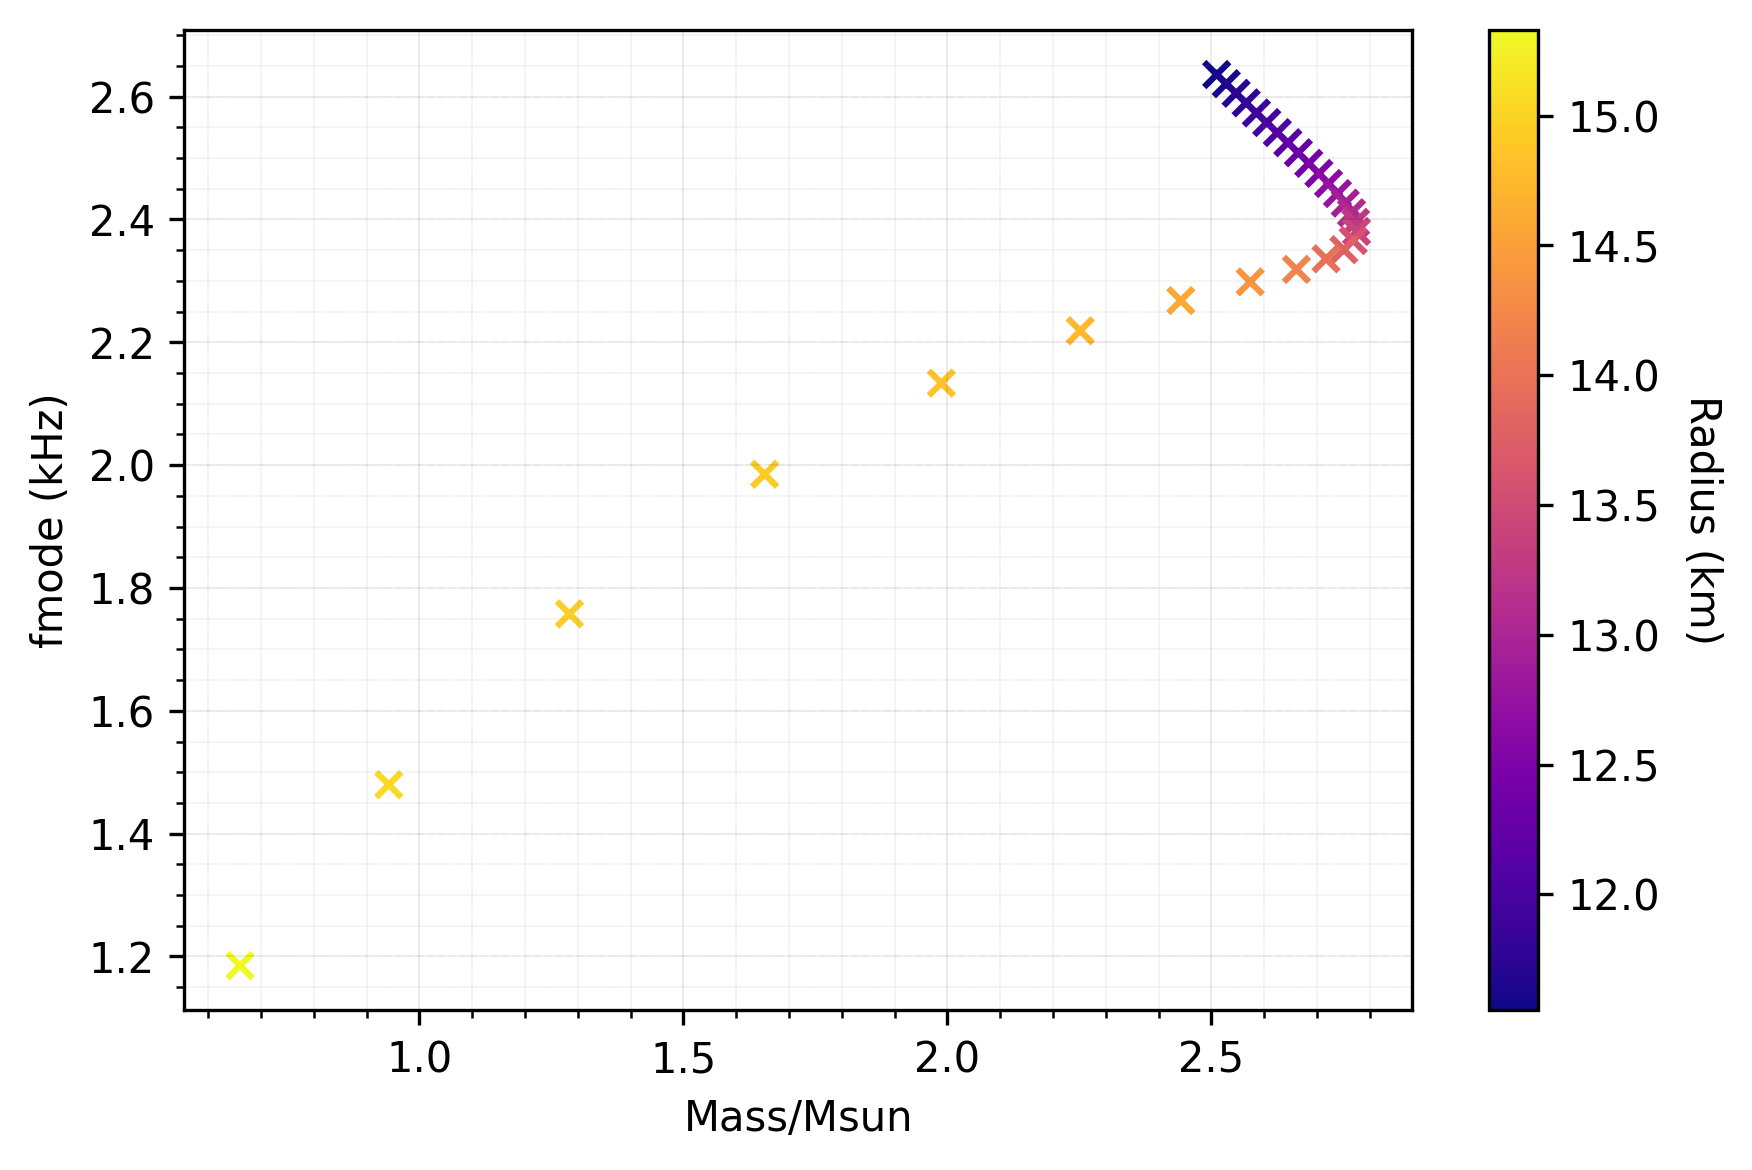

In [10]:
mass_arr = np.array(mass_list)
f_mode_arr = np.array(f_mode_list)
radius_arr = np.array(radius_list)
hz2khz = 1e-3

plt.figure(dpi = 300)
plt.tight_layout()
plt.scatter(mass_arr/msun, f_mode_arr*hz2khz, c = radius_arr/km2cm, marker = "x", 
            cmap = "plasma")
plt.xlabel("Mass/Msun")
plt.ylabel("fmode (kHz)")
cbar = plt.colorbar()
cbar.set_label('Radius (km)', rotation=-90, labelpad=15)
utkarshGrid()
# plt.xlim(1, 3)
# plt.ylim(1.5, 3)
plt.show()